# Predicting Omega
Given a trained network use this document to predict the values of Omega to produce a desired $J_{i,j}$.


In [1]:
import sys
sys.path.insert(0, '/Users/marinadrygala/Desktop/Marina/')
import classesmu
from classesmu import BatchSimulatedSpinLattice as bsslmu
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import time
import ic_functions
from ic_functions import chain, circle
import neural_nets
from neural_nets import Net
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Instructions
Enter the path of the saved model to the path variable.

In [3]:
path = '/Users/marinadrygala/Desktop/Marina/mu_fixed/Less_Mus/N=10/m=9_Data_Size_25000_Error_0.2182_Time_1258.69_Epochs_87.pt'
d = torch.load(path)
"""The required items from the file are stored are variables."""
ic = d['ic']
mu=d['mu']
m=d['m']
test_set=d['test']
N=ic.n
input_size = int(N*(N-1)/2)
output_size = N*m
hidden_size = 128*(N-2)
#input_size = d['input_size']
#hidden_size = d['hidden_size']
#output_size = d['output_size']

"""The trained model is loaded"""
model = Net(input_size, hidden_size, output_size)
model.load_state_dict(d['model_state_dict'])
optimizer = torch.optim.Adam(model.parameters())
optimizer.load_state_dict(d['optimizer_state_dict'])
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.double()

model.double()



Net(
  (fc1): Linear(in_features=45, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=90, bias=True)
)

## Instructions C'td
Enter the desired $J_{i,j}$ value or set of values in the variable Jij. Note make sure the values are normalized by dividing by the L2-norm.

In [4]:
"""Network Predictions"""
#Jij = test_set[3]
Jij=torch.tensor(chain(N)/np.linalg.norm(chain(N)))
if len(Jij.size())==1:
    Omega_pred = model(Jij).view(1,N,m)
else:
    Omega_pred = model(Jij).view(Jij.size()[0],N,m)
Jij_pred = bsslmu(ic, mu, Omega_pred, dev=device).normalize()
Error = torch.mean(torch.abs(Jij-Jij_pred))*100
print('Predicted Omega values\n', Omega_pred)
print('Jijs give by Omegas predicted\n', Jij_pred)
print('Mean error\n', Error.item())

Predicted Omega values
 tensor([[[-31.2586,  10.2382,   2.6232,  49.8179,   9.0002,  20.9272,  -0.8566,
          -13.9947,  74.3302],
         [-21.3610,  29.2632,   8.8525,  -9.1520,  -1.6237,  20.9353, -24.5989,
          -13.0161,   6.5193],
         [ -1.8438,  -5.2382, -51.5458,  -6.3717,   7.1585,   4.7198,   1.6974,
           -0.0849,   4.4875],
         [ -5.5407,   0.4438,   5.7286,  -1.6522,   0.0450,   1.5321,  -0.4545,
            0.9107,  -0.0204],
         [ 49.5706,  -8.8036,   1.3447,  -2.7415,   0.2109,   4.8843,  -1.5914,
            4.0776,  -5.1576],
         [ -1.8134,  10.8441,  -5.7389, -41.3230, -14.0601,  11.6465,  -2.3774,
           11.3635, -39.2467],
         [  0.1568,  -3.9039,   1.8633,  -5.8363, -49.6986,   7.4986,   6.3340,
           -4.2484,  -8.8003],
         [  9.6131, -42.6969,  -1.5516,   0.4551, -32.9495, -10.7734,   2.6459,
           -0.5390, -13.1993],
         [ -9.4184,   4.8837,   1.3016,  20.6605,  -3.3072,  -9.4394,  -9.2700,
        

In [5]:
"""A comparision of the absolute sizes of the Rabi frequencies corresponding to each detuning. Used to predict which
mu value may be possible to eliminate and still retain some accuracy."""
numerator=torch.einsum('pnm->pm',[abs(Omega_pred)])
print(numerator)
denominator=torch.einsum('pnm->p',[abs(Omega_pred)])
print(denominator)
epsilon=torch.einsum('pm,p->m',[numerator,1/denominator])
print(epsilon)
norm_epsilon=torch.sqrt((epsilon ** 2).sum(0))
print(norm_epsilon)
normalized_epsilon=epsilon/norm_epsilon
print(normalized_epsilon)

tensor([[140.4574, 125.0189,  91.1861, 148.6494, 131.3935, 107.6662,  74.4392,
          71.8517, 219.5159]],
       dtype=torch.float64, grad_fn=<SqueezeBackward3>)
tensor([1110.1783], dtype=torch.float64, grad_fn=<SqueezeBackward3>)
tensor([0.1265, 0.1126, 0.0821, 0.1339, 0.1184, 0.0970, 0.0671, 0.0647, 0.1977],
       dtype=torch.float64, grad_fn=<AsStridedBackward>)
tensor(0.3529, dtype=torch.float64, grad_fn=<SqrtBackward>)
tensor([0.3585, 0.3191, 0.2327, 0.3794, 0.3353, 0.2748, 0.1900, 0.1834, 0.5603],
       dtype=torch.float64, grad_fn=<DivBackward1>)


Text(0.5,1,'Scaled value')

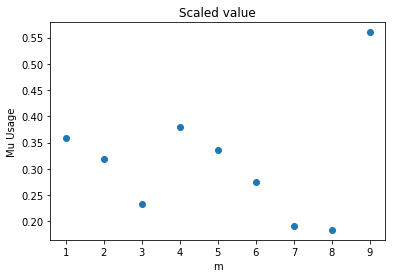

In [6]:
"""Visualization of the above calculations"""
plt.plot(range(1,len(epsilon)+1),list(normalized_epsilon),
            marker='o',linestyle='None')

plt.ylabel('Mu Usage')
plt.xlabel('m')
plt.title('Scaled value')

In [7]:
"""Determine which indices of the original mu were removed, incase the user wishes to remove more, and produce a
new data set."""
print(d['removed_mus'])
print(d['mu'])

[6]
tensor([2.0442, 2.7688, 3.2992, 3.7195, 4.0630, 4.3466, 4.7665, 4.9091, 5.0500])
